# Simulations: Dynamic learning with two learners, one oracle, and *heuristic evidence-weighting function*

This notebook provides code to simulate 1D boundary learning in two agents learning from each other and from an "oracle" that always tells the truth. Each agent receives labels from the other agent (based on her current belief) and from the oracle (based on the ground truth). Neither agent knows which source is telling the truth.

Each agent begins with an initial belief about the location of the category boundary, so that the two agent beliefs together can be viewed as a point in a 2D plane. Across one "batch" of learning, it is assumed that each agent moves her boundary toward a weighted average of the difference between her current boundary and the boundaries of the other two sources (ie, the other learner and the oracle). So:

$$\Delta_b = w_c * d_c + (1 - w_c) * d_f$$

...where $\Delta_b$ is the change in the learner's boundary, $w_c$ is the (proportional) weight given to the closer source, $1-w_c$ is the (proportional) weight given to the more distal source, and $d_c$ and $d_f$ are the distances from the closer/more distal source to the learner's current boundary.

The amount moved on each batch is determined by a fixed rate parameter r:

$$b_{t+1} = b_t + r * \Delta_b$$

As shown in the empirical studies, the proportional weight given to each source is determined by a function that decays nonlinearly with the distance between the source's boundary and the learner's curent boundary:

$$w_c = 1 - (d_c + o)/(d_c + o + s)$$

...where $d_c$ is the distance from the learner's boundary to the closer source, $o$ is an offset term (distance considered 0 if less than $o$), and $s$ controls the slope of the decay. The defaults for $o$ and $s$ are the best-fitting parameters determined in Experiment 2.

The functions and code are as follows:

get.pwt: given a distance between learner's boundary and source, and parameters for the trust decay, return weight given to source.

update.bound: given the learner's boundary, a current boundary for each source, a rate constant, and parameters for the decay curve, return the learner's new boundary.

dynamic.sim: given starting boundaries for each learner, the true boundary, a learning rate constant, number of batches, and parameters for the trust decay curves, reutrn a matrix indicating each learner's boundary at each epoch of learning.


## Heuristic evidence-weighting function

This function computes the weight given to a source as a function of its distance from the learner's current boundary, according to the heuristic evidence-weighting function determined in Experiment 2. This is a proportional weight $w_c$ relative to some fixed second source, which in turn receives a weight of $1 - w_c$. The empirical studies showed that $w_c ~= 1$ when the source boundary is within $o$ of the learner's boundary--therefore in simulations, we compute $w_c$ for the closest source boundary, then give the remaining $1-w_c$ weight to the second source.

In [1]:
get.pwt <- function(d, s=24, o=5, p=1){
    #Computes the proportion of weight given to a source
    #based on the distance between learner and source boundary
    #
    #d = vector of distances between learner and source boundary for n sources
    #s = slope of HEW curve
    #o = offsetof HEW curve---distances less than this value will return an output value of 1.0
    #p = power to which resulting proportion is raised. Experimental, use default of 1.0
    #out = returned vector of proportional weights for far source
    ###################
    
    d <- d - o  #Shift distances by offset so d = o becomes d = 0
    tmp <- 1 - (d/(d+s))   #Proportional weight given to distal source
    tmp <- c(tmp)^p        #Raise to power p, not currently used
    tmp[tmp > 1] <- 1.0    #If weight is larger than 1 replace with 1
    tmp
}

Here is what the weighting function looks like with default parameters from experiment 2, where s = 24 and o = 5:

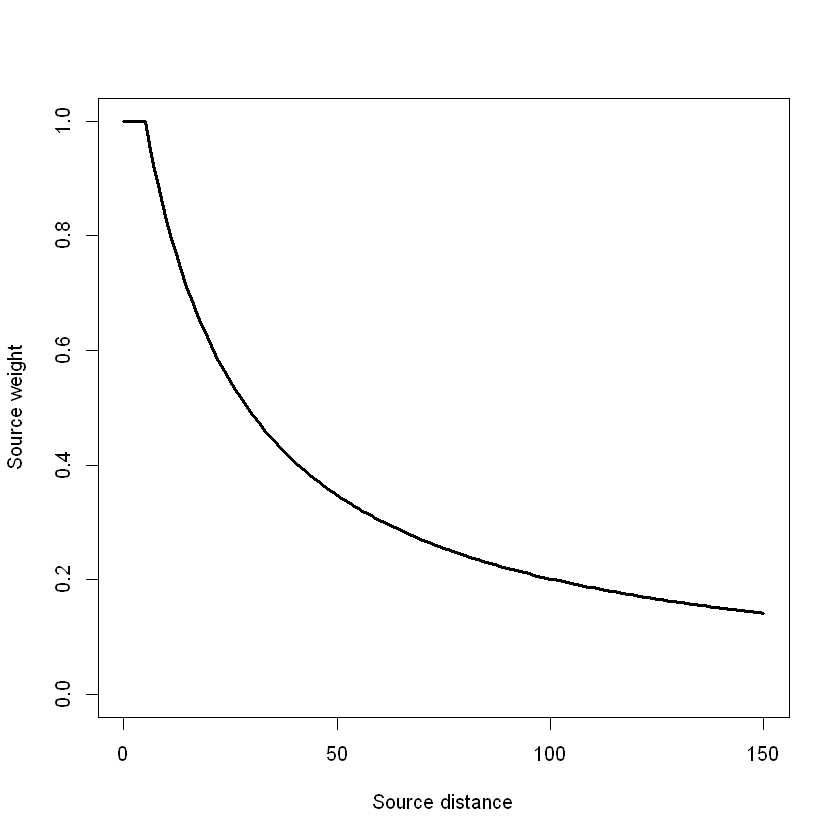

In [2]:
plot(0:150, get.pwt(0:150, s=24, o=5), type = "l", lwd = 3, pch = 16, ylab = "Source weight", xlab = "Source distance", ylim = c(0,1))



## Other possible weighting functions

Here we define some other weighting functions to investigate group learning dynamics under different hypotheses about weighting.

### Equal weight to both sources

This function can be used in place of get.pwt to simulate learning where both sources always get equal weight.

In [3]:
get.samewt <-function(d, s=NA, o=NA, p=NA){
    #Returns a vector of 0.5 for each element of d
    #essentially always giving the same .5 weight to each source
    #All parameters ignored except d, only included to work with other code
    #############
    
    out<-rep(.5, times=length(d))
    out
}

### Rectified linear weighting

This function returns the weight of a source based on a linear decline of the source's distance from the learner's curent boundary, rectified at 0 and 1.

In [4]:
get.rlwt <- function(d, s=0.01, o=4.5,p=0){
    #Rectified linear weighting function
    #d = vector of distances for sources to be weighted
    #o = offset; distances less than this get weight 1
    #s = slope, rate at which weight diminishes with distance
    #p = proportion shrinkage from 1 and 0.
    #Returns vector of weights, one for each element in d
    #############
    
    out <- 1 - ((d - o) * s)
    out[d <= o] <- 1.0
    out[out < 0] <- 0.0
    out <- (out * (1-p)) + p/2
    out
}

Here is what the rectified weighting function looks like. $o$ shifts it left/right, $s$ changes the slope.

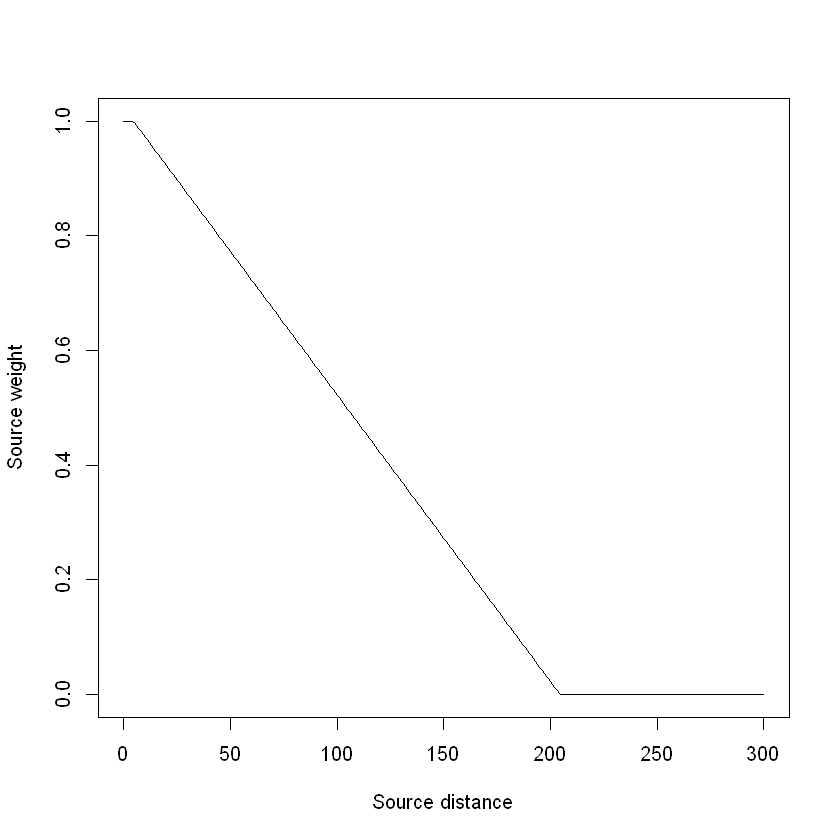

In [5]:
plot(0:300, get.rlwt(0:300, s=.005, o=4.5, p=.0), type="l", ylim = c(0,1),
     ylab="Source weight", xlab="Source distance")

## Sigmoid

This returns a source weight as the sigmoid of its distance from the learner's source. Like HEW and rectified linear, the function is bounded at ${0,1}$.

In [6]:
get.sigwt <- function(d, s=1, o=4.5,p=NA){
    #Sigmoidal weighting function
    #d = vector of distances for sources to be weighted
    #o = offset, shifts sigmoid left/right
    #s = slope of sigmoid
    #p = for compatibility, not used
    #Returns vector of weights, one for each element in d
    #############
    d <- c(max(d) - d) - max(d)/2
    out <- 1 / (1 + exp(-1 * (o + s*d)))
    out
}

Here is the plot:

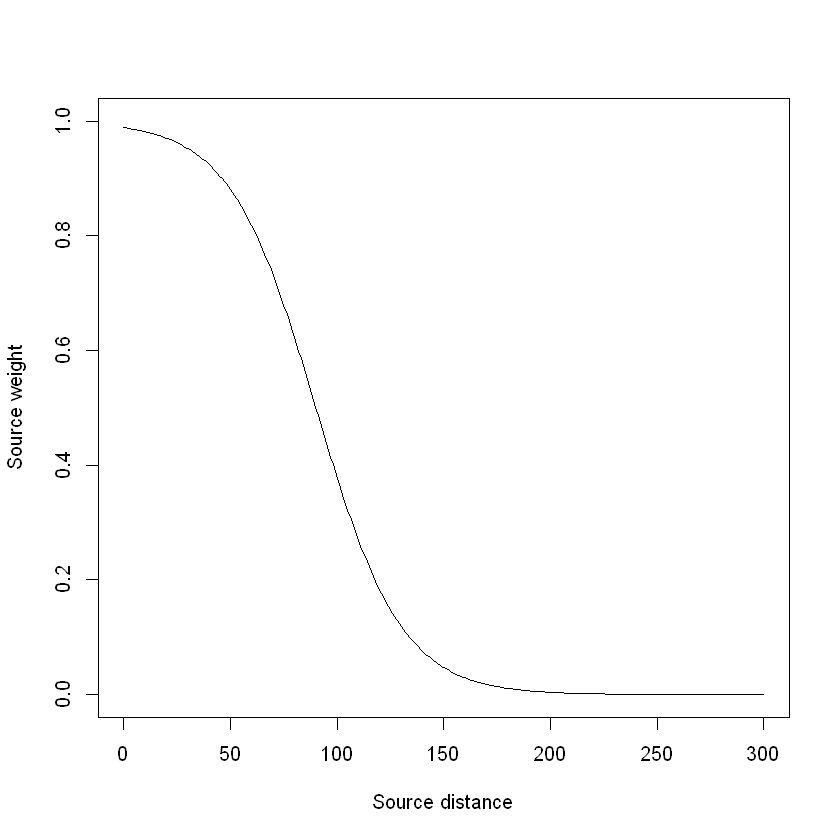

In [7]:
plot(0:300, get.sigwt(0:300, s=.05, o=-3), type="l", ylim = c(0,1),
     ylab="Source weight", xlab="Source distance")

## Update the learner's current boundary according to evidence-weighting function.

Note that different results obtain depending on whether you use the curve to compute the close source weight first or the far source weight first. Both lead to stable states where learners disagree, but Experiment 2 shows that a source with a very close boundary receives all the learner's weight--so we typically compute the closest source weight first and attribute remaining weight to the second source.

In [8]:
update.bound <- function(i, s1, s2, r = 1, weightfirst ="c", closebig=T, f = get.pwt, fpars=c(24, 5, 1)){
    ##############
    #Updates learner's current boundary accourding to nonlinear weighting function
    #
    #i=learner's initial boundary
    #s1, s2 = source 1 and 2 boundaries
    #r = rate of boundary change
    #f = function to use for weighting, get.pwt by default
    #fpars = parameters for the weighting function: slope, offset, power
    #closebig: is the closer boundary toward the larger end of the stimulus range?
    #weightfirst = which source to weight first---default (c) is closest, use anything else for distal
    #returns the new boundary
    ######

    #Determine which is closer and which is distal source
    if(abs(i-s1) < abs(i-s2)){
        cs <- s1
        ds <- s2
        } 
    else{
        cs <- s2
        ds <- s1
        }
    
    #Use function f to compute weights for two sources
    if(weightfirst=="c"){ #If close source is computed first
        cwt <- f(abs(cs-i), s=fpars[1], o=fpars[2], p=fpars[3]) #get weight for close source first
        if((cwt < 0.5) & closebig) cwt <- 1 - cwt #closer source gets larger weight if closebig is true
        dwt <- 1 - cwt  #Weight for more distal source
        } 
        else{ #If distal source is computed first
            dwt <- f(abs(ds-i), s=fpars[1], o=fpars[2], p=fpars[3]) #get weight for distal source first
            cwt <- 1 - dwt  #Weight for closer source
        }
    
    delta_i <- (ds-i) * dwt + (cs-i) * cwt  #Change in boundary
    i <- i + delta_i * r                    #update boundary
    i
}

# Simulate two learners and one static source

This simulation involves two learners and one oracle, as reported in the main paper. The following function generates the sequence of belief-states occupied by each learner over the course of learning, given their starting states, the ground truth, one of the evidence-weighting functions defined above and its parameters, and a constant indicating how quickly beliefs are updated on each round.

In [9]:
dynamic.sim <- function(l1, l2, static, nsteps=100, r=1, f = get.pwt, fpars=c(25,5,1)){
    #Simulates two learners, learning from each other and from one static source
    #l1, l2, static  = initial boundaries for learners 1 and 2 and static source
    #nsteps = number of learning steps to simulate
    #r = updating rate for each learner's boundary
    #fpars = parameters for nonlinear weighting function
    
    out <- matrix(0, nsteps, 2) #matrix to contain each learner's boundary at each step
    out <- rbind(c(l1,l2), out) #add initial boundaries to top of matrix

    #Loop to update each learner's bound based on other learner and static bound at previous step
    for(i1 in c(1:nsteps)){
        out[i1+1,1] <- update.bound(out[i1,1], out[i1,2], static, r=r, f=f, fpars=fpars)
        out[i1+1,2] <- update.bound(out[i1,2], out[i1,1], static, r=r, f=f, fpars=fpars)
    }
    out
}

## Plot simulations for a grid of possible initial learning boundaries in the pair

The code below runs the 2-learer simulation several times, with the two learners each beginning with a belief about the category boundary lying  somewhere between 0 and 300. For each pair of initial beliefs, it computes how the beliefs change over time and where they stop after 100 "epochs" of learning. Each such trajectory is plotted as a gray line, with the starting beliefs shown as a green point and the ending beliefs shown as a red point. 

Parameters controlling the simulation are ste at the top of the block as follows:

**gridpts** sets the number of starting beliefs simulated for both learners; these will be evenly-spaced in $[0-300]$.

**gtruth** specifies the location of the ground truth provided by the oracle.

**niter** indicates the number of learning iterations to run.

**uprate** is a constant specifying the rate at which beliefs are updated. 

**upfunc** indicates which of the above-defined functions should be used to weight the sources

**upfunc.pars** is a 3-element vector indicating the slope, offset, and power parameters for the weighting function in that order

To reproduce main paper Figure 4A use upfunc <- get.samewt; for panel B use upfunc <- get.pwt

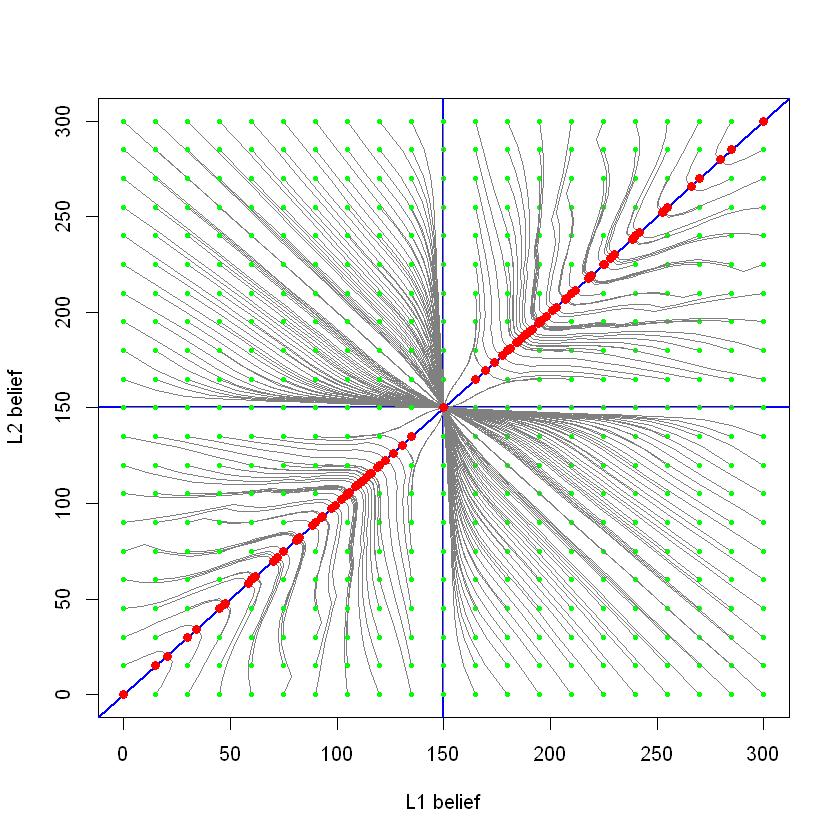

In [10]:
gridpts <- 20 #Number of grid points in each dimension
gtruth <- 150 #Location of ground-truth boundary
niter  <- 200 #Number of learning iterations
uprate <- 0.1 #Proportional rate at which beliefs are updated on each iteration
upfunc <- get.pwt #Function for computing source weights
upfunc.pars <- c(24,5,1) #Parameters for weighting function

#Create empty plot frame:
plot(150, 150, type="n", xlim = c(0,300), ylim = c(0,300), xlab = "L1 belief", ylab="L2 belief")
abline(0,1, lwd=2, col = "blue") #line where learners have same boundary
abline(h=150, lwd=2, col = "blue") #ground truth at 150
abline(v=150, lwd=2, col = "blue") #ground truth at 150

grspace <- floor(300/gridpts) #Compute grid spacing

for(i1 in c(0:gridpts)) for(i2 in c(0:gridpts)){ #loop over grid points for l1 and l2
     #for each iteration compute learners boundary trajectories
    tmp <- dynamic.sim(i1*grspace, i2*grspace, gtruth, nsteps = niter, r=uprate, f=upfunc, fpars = upfunc.pars)
    lines(tmp, col=gray(.5)) #add lines showing trajectory
    points(tmp[1,1], tmp[1,2], pch = 16, col = "green", cex=.5) #start point
    points(tmp[niter+1,1], tmp[niter+1,2], pch = 16, col = "red")       #end point
    }


As you can see, when learner beliefs begin in the upper left or lower right quadrants, they converge on the truth. These are cases where each learner begins on a different side of the ground truth--so the oracle and the other source are always pulling in the same direction. The two learners do not perfectly agree until they meet at the ground truth. Something different happens in the upper right and lower left quadrants, where the two learners are on the same side of the ground truth. In these cases the two learners often end up agreeing with each other, and hence giving each other all their weight, before they meet at the ground truth. This then produces different groups of beliefs, depending on where the learners began. The same behavior is observed for all nonlinear weighting functions.

## Explaining the experimental data

Does this weighting curve allow us to explain the pattern of results in the 4 experiments? 

Experiments 1 and 2 are fairly straightforward: the parameters for the weighting function were derived from Experiment 2, where one source always appeared 15 units from the midline, and the other was sampled with uniform probability from $b_v \in [0,150]$ units from the midline. Since experiment 1 also used a source 15 units from the midline, the same parameters for the weighting function should apply. Simply plugging in the experiment design parameters to the update.bound function gives us the predicted new boundary after learning, and hence the expected amount of shift, and the amount of weight given to the far source:

In [11]:
firstbound <- 150 #Expected initial boundary
newbound <- update.bound(150, 165, 50, fpars = c(25,4.5,1), weightfirst = "d") #new boundary after updating weight
bshift <- newbound - firstbound #expected amount of shift
dwt <- get.pwt(100) #expected weight given to far source
print(round(c(firstbound, newbound, bshift, dwt),2))

[1] 150.00 141.14  -8.86   0.20


So given an initial boundary at 150 and sources at 165 and 50, the weighting curve from Experiment 2 predicts a final boundary around 141, with a total shift of about 9 units toward the distal source. The observed shift wa 14 +/- 7.5 units toward the far source, a confidence interval that includes this prediction. The curve also predicts a weight of about 0.2 given to the far source, quite close to and within the confidence limits of the empirical estimate of 0.23 +/- 0.05.

What about experiment 3? This was motivated by the observation that, according to the curve in Experiment 2, a learner should give all weight to a source that is v close to her initial belief. So that is a fairly trivial prediction---total weight given to each group's close source should be 1; that source is very near the learner's boundary; the boundary does not change, which is what we observed.

Experiment 4 is the most challenging to think about. We want to know what the model predicts about boundary change when the learner has a boundary about 50 units from the midpoint and the two sources are symmetric around the midpoint but vary in their distance. Clearly when the two sources are both very close to the midpoint, the learner should shift her boundary toward the midpoint. And we know that, when one source grows near to the learner's boundary, it should get all the weight and the learner's boundary should not shift very much. But what happens as the sources grow more discrepant, with one pulling the learner toward one extreme and the other pulling the learner toward the other extreme?

Predictions from the weighting model are complicated by the fact that we only estimated parameters for the case in which one source is about 15 units from the learner's initial boundary. We don't know how/whether the slope of the weighing function will change when both sources differ in their distance from the initial boundary. So, we don't know exactly how the boundary is expected to change. Here we consider whether the model makes predictions that apply across a wide range of parameterizations.

The code below considers models in which the slope parameter varies from 16 (quite steep) to 100 (fairly shallow). For each parameter, we consider what the model predicts about how the boundary should change for sources situated near the midpoint or increasingly distal to it. For each model parameter, we plot a line that indicates the expected movement of the boundary, with positive numbers indicating a shift toward the midpoint and the X-axis indicating source distance from the midpoint. The colors indicate the steepness of the weighting function, with the red end of the spectrum showing what happens when this slope is very steep and the violet end showing predictions for much shallower slopes

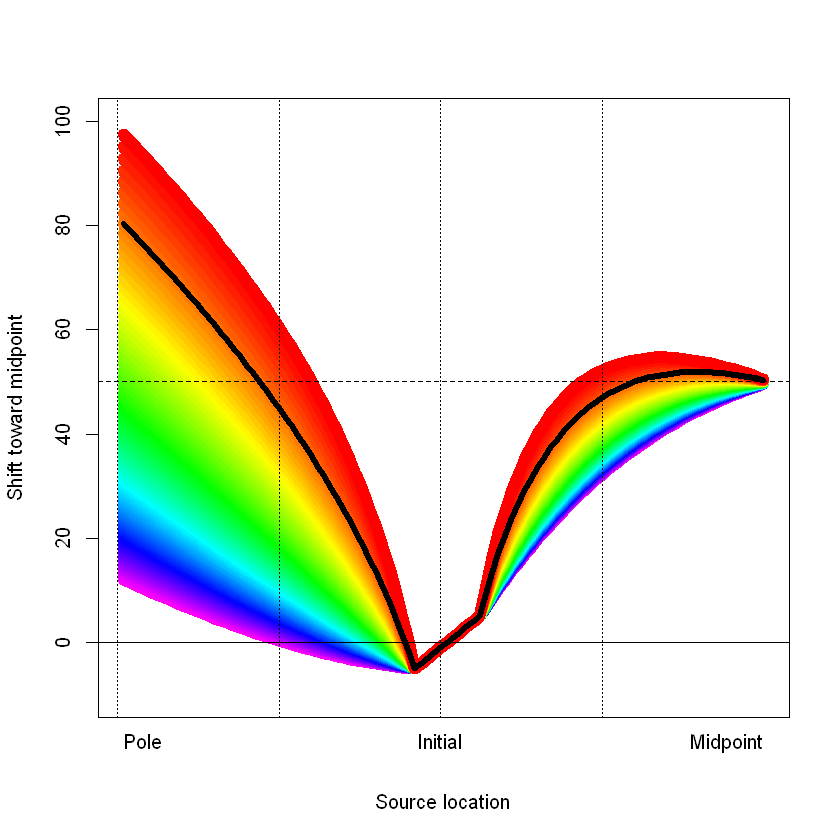

In [12]:
tmp <- rep(0, times = 100) #vector of zeros to contain predictions for one model
#for(i1 in c(1:100)) tmp[i1] <- update.bound(100, 150-i1, 150+i1, fpars = c(24,5,1))

#Create empy plot
plot(0,0, type = "n", xaxt = "n", xlab = "Source location", pch = 16, 
     ylab = "Shift toward midpoint", ylim = c(-10,100), xlim = c(1,100))
mtext(side = 1, line = .5, at = c(100,50,1), adj = c(1,.5, 0), text = c("Midpoint", "Initial", "Pole"))

#Consider slope values ranging from 100 to 16
for(i2 in c(100:16)){
    #For each, compute prediction about how boundary changes as sources move
    #from midline to poles, and plot as a line
    for(i1 in c(1:100)) tmp[i1] <- update.bound(100, 150-i1, 150+i1, closebig=F, fpars = c(i2,5,1))
    lines(100:1, tmp-100, col = rainbow(100)[i2-15], lwd=10)
    }

for(i1 in c(1:100)) tmp[i1] <- update.bound(100, 150-i1, 150+i1, closebig=F, fpars = c(24,5,1))
lines(100:1, tmp-100, col = 1, lwd=5)


abline(h=50, lty=2) #Expected shift if they go to midpoint
abline(h=0)         #Points above this line indicate shift toward the midpoint

abline(v = c(75, 50, 25,0), lty = 3)

The result shows that quantitative predictions about the amount of shift vary quite a bit with the parameters of the trust weighting function, especially as the sources grow further toward the poles. But all parameterizations yield the same U-shape: when the sources are closer to the midpoint than is the learner's initial boundary, the boundary is expected to shift toward the midpoint. For a "bubble" around the learner's initial boundary, little or no shift is expected, but as the sources grow even closer to the poles, all parameterizations predict that the boundary should again shift toward the midpoint. So the weighting model makes a qualitative prediction robust under several parameterizations: learner boundaries should shift toward the midpoint when the two sources are both near the midpoint, and *also* when they are far from the midpoint. In between there should be a bubble where learners shift their boundary less or not at all. 

This is the prediction tested in Experiment 4, where we observed a boundary-shift toward the midpoint of about 20 units when the two sources were near the midpoint (strong agree condition) *and* when they were both far from the midpoint (strong disagree condition), with no shift observed when sources were at intermediate distances from the midpoint (moderate-agree and moderate-disagree conditions). In the main paper we note this pattern is qualitatively similar to the U-shaped curve shown by the HEW model under different parameterizations as shown above, but it is also quantitatively similar to predictions of a heuristic evidence-weighting function with a somewhat shallower slope than that estimated in Experiment 2. 

In case it is useful, here is some code plotting the shape of the weighting curves corresponding to the parameters that produce the above figure.

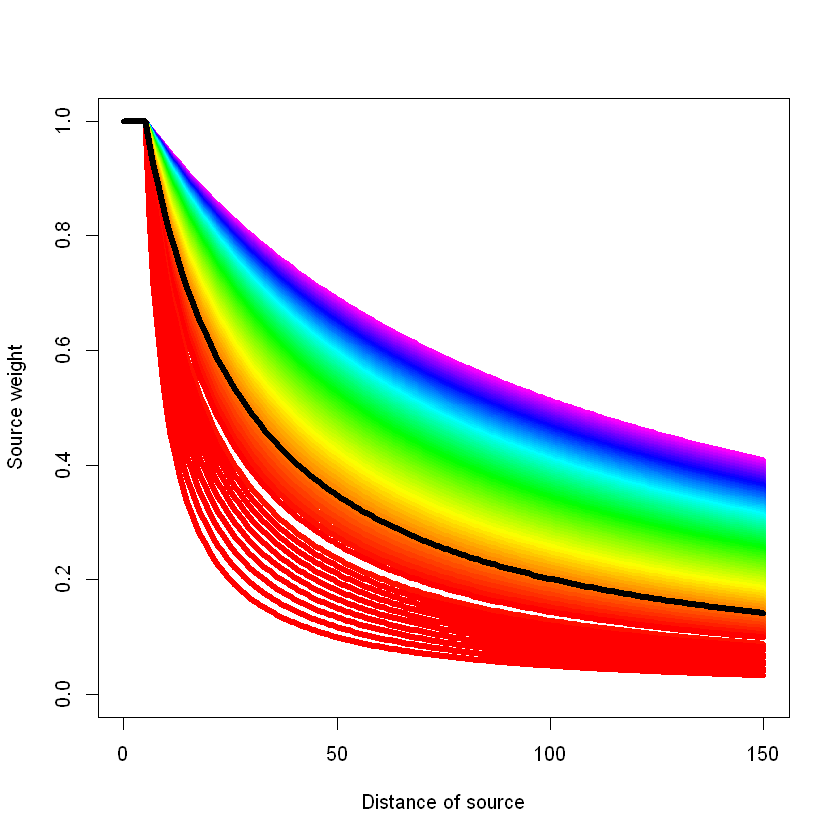

In [13]:
plot(0,0,type = "n", xlim = c(0,150), ylim = c(0,1), xlab = "Distance of source", ylab = "Source weight")
for(i1 in c(100:5)) lines(0:150, get.pwt(0:150, i1, 5, 1), col = rainbow(100)[i1-15], lwd = 5)
lines(0:150, get.pwt(0:150, 24,5,1), col=1, lwd = 5)

# Effects of social connections amongst learning pairs

In the above simulation of dynamic learners we considered pairs of learners with many different initial beliefs, each learning from the other and from a static oracle. What happens in a group of learners, where the two sources for any single learner are selected according to some policy on each epoch? For instance, suppose you run a social media platform and you want to decide which opinions to "share" with each learner. On each epoch, for each learner, you must choose two opinions to share. Here are some of the ways you might pick:

(1) two sources selected at random
(2) the two closest sources
(3) the closest and the fartherst source
(4) the two farthest sources
(5) the two closest sources *outside the bubble*

The following code considers these possibilities. The function get.srcs takes a set of source boundaries and a learner's current boundary, and returns two source boundaries according to one of the policies noted above. The subsequent code shows what happens to 10 learners when that policy is applied over successive learning batches.


### Function for selecting two sources for a learner under different policies

Given a learner's boundary and a set of source boundaries, return two sources for the learner according to some policy.

In [14]:
get.srcs <- function(l, s, p = "r", r=NA){
    #Function to get two source distances for a learner based on a policy
    #l = learner's current boundary
    #s = current boundary for all sources
    #p = policy for choosing 2 sources:
        #r = random
        #s = two most similar
        #m = mixed ie most similar and most distal
        #f = two farthest sources
        #n = not too similar: choose closest outside of bubble
    #r = radius of similarity to avoid for policy n
    #o = outputs, returns distances for the two selected sources
    ###################
    d <- s - l #vector of distances from learner's boundary
    s <- s[order(abs(d))]  #Sort sources by magnitude of distance
    d <- d[order(abs(d))]  #Sort distances by magnitude of distance
    s <- s[2:length(s)]   #remove first source, which is the learner herself
    d <- d[2:length(d)]   #remove first distance, which is the learner herself
    
    if(p=="r"){ #random policy
        s <- s[order(runif(length(s)))] #scramble order randomly
        o <- s[1:2] #take first two elements
    } else if(p=="s"){ #two most similar policy
        o <- s[1:2]
    } else if(p=="m"){ #closest and farthest
        o <- s[c(1, length(s))]
    } else if(p=="f"){ #farthest 2
        o <- s[c(length(s)-1, length(s))]
    } else if(p=="n"){
        if(is.na(r)) stop("Radius for policy n not specified")
        if(sum(abs(d) > r) > 1){ #If there is at least 1 source outside radius
            s <- s[abs(d) > r] #Remove sources within exclusion radius
            o <- s[1:2] #Select closest two of those remaining
        } else o <- s[c(length(s)-1, length(s))] #otherwise take two farthest
    } else stop("Didn't recognize specified policy")
    o
}

Check to make sure the code works

In [15]:
get.srcs(5, 1:10, p="n", r=2)

[1] 2 8

## Functions to simulate a population

The following code populates a matrix (out) in which columns indicate learners/sources and rows indicate learning epochs. For each epoch and learner, the code selects two sources according to some policy, as determined by the get.srcs function. The learner then updates her boundary according to the specified weighting function. Each learner updates her boundary once per epoch. This procedure iterates for 100 batches.

To see the results of different policies for selecting sources for a learner, use the following values for policy as an argument in the following function:

r = random
s = two most similar
f = two farthest (most dissimilar)
m = mixed (closest and farthest)
n = not-too-similar: closest sources outside some exclusion radius
**note**: for policy n, you need to specify the exclusion radius by also setting a value for exrad

In [16]:
sim.pop <- function(l=c(1:10)*14, o=150, nsteps=300, rate=.1, policy="r", exrad=5){
    init<-c(l, o) #Initial boundaries for learners and oracles
    nl <- length(l) #number of learners
    no <- length(o) #number of oracles
    ns <- length(init) #total number of sources
    out <- matrix(0, nsteps+1, ns) #Initialize output matrix
    out[1,] <- init #Seed first row with starting boundaries
    for(i1 in c(1:nsteps)) { #loop over batches
        for(i2 in c(1:nl)) { #loop over learners
            sdists <- get.srcs(out[i1,i2], out[i1,], p=policy, r=exrad) #get sources for learner i2
            out[i1+1,i2] <- update.bound(out[i1,i2], sdists[1], sdists[2], r=rate) #update learner's boundary
        }
    out[i1+1,(nl+1):(nl+no)] <- out[i1,(nl+1):(nl+no)] #oracle boundaries are always the same
    }
    out
}

In [32]:
out <- sim.pop(policy="r")

The following code plots the change in learner boundaries over time generated by the preceding code.

In [17]:
plot.popsim <- function(d, nl=10){
    no <- dim(d)[2] - nl  #Number of oracles
    nsteps <- dim(d)[1] -1

    #Plot initial boundaries and frame:
    plot(rep(0, times = nl), d[1,1:nl], pch=16, col = 3, xlim = c(0,nsteps), ylim = c(0,300), 
     ylab = "Boundary", xlab = "Time")

    #Add lines showing how each learner's boundary changes over time:
    for(i1 in c(1:nl)) lines(c(0:nsteps), d[,i1])

    #Show final bondary as red dot:
    points(rep(nsteps, times = nl), d[nsteps+1,1:nl], pch = 16, col = 2, cex = 2)

    abline(h=d[1,c((nl+1):(nl+no))], lty = 2) #Dotted lines showing oracle boundaries
}

Below code runs simulation with two oracles at 150 and random initial beliefs sampled from 10-200. Change the policy parameter to one of the above to see the result of different source-selection policies.

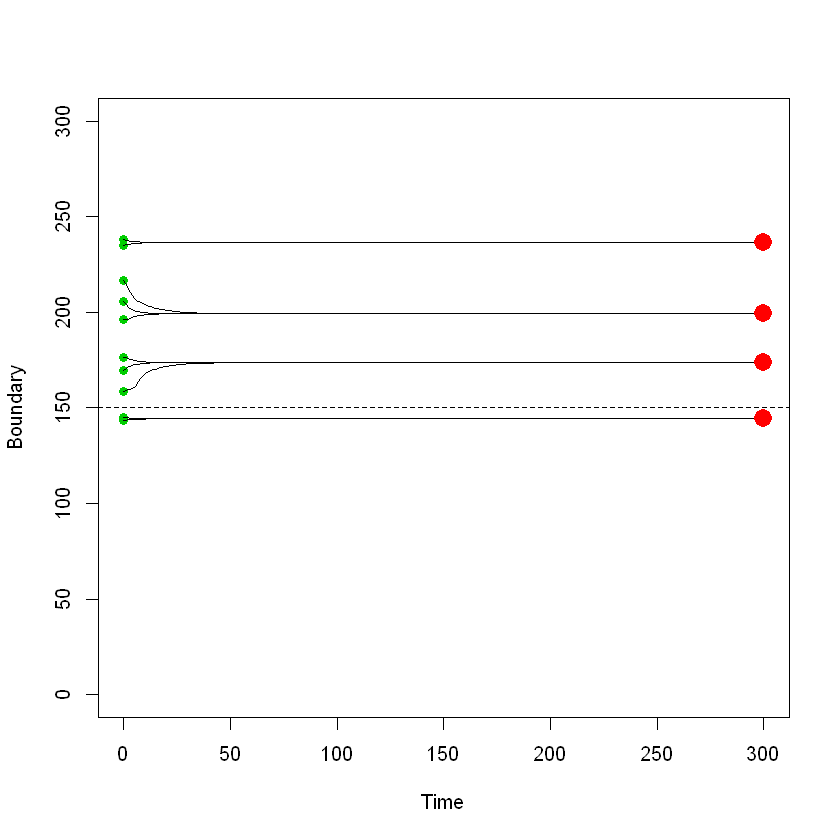

In [43]:
n <- 10 #Number of simulated agents
no <- 2 #Number of oracles
gt <- 150 #ground truth provided by oracles
ibspan <- 100 #Maximum span of initial learner belief distribution
ibshift <- 140 #Shift from 0 of initial learner belief distribution
p <- "m" #Policy for selecting sources, one of: 
         #r = random s = two most similar, f = two farthest (most dissimilar)
         #m = mixed (closest and farthest), n = not-too-similar

#Initial beliefs will be sampled uniformly from ibshift to (ibshift + ibspan)

ibounds <- runif(n)*ibspan + ibshift #Sample initial beliefs for n learners

#Run simulation
out <- sim.pop(l=ibounds , o=rep(gt, times = no), policy=p, rate = .1)

#Plot results
plot.popsim(out, nl=n)

In [44]:
#Compute mean absolute change by end of learning period
chng <- out[2:301,] - out[1:300,]
mean(abs(chng[300,1:10]))


[1] 5.684342e-15

In [39]:
sqrt(var(out[301,1:10]))

[1] 0.3405354